In [ ]:
# NAMA : EDWARD
# KELAS : BB08
# HARI, TANGGAL : Sabtu, 19 Desember 2020

In [202]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [203]:
training = spark.read.option("inferSchema","true").csv("Data/Clustering/Healthylyfe_Train.csv",header=True)
testing = spark.read.option("inferSchema","true").csv("Data/Clustering/Healthylyfe_Test.csv",header=True)

In [204]:
training = training.select("Diet", "Exercise", "Sleep Quality")
testing = testing.select("Diet", "Exercise", "Sleep Quality", "Healthy")

In [205]:
training = training.na.drop()
testing = testing.na.drop()

In [206]:
from pyspark.sql.functions import when

training = training.withColumn("Sleep Quality", when(training["Sleep Quality"] == "Poor", 0).
                                                  when(training["Sleep Quality"] == "Average", 1).
                                                  when(training["Sleep Quality"] == "Good", 2))

testing = testing.withColumn("Sleep Quality", when(testing["Sleep Quality"] == "Poor", 0).
                                                when(testing["Sleep Quality"] == "Average", 1).
                                                when(testing["Sleep Quality"] == "Good", 2))

testing = testing.withColumn("Healthy", when(testing["Healthy"] == "No", 0).
                                         when(testing["Healthy"] == "Yes", 1))

In [207]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

colsTrain = training.columns
colsTest = testing.columns
colsTest.remove("Healthy")

training = VectorAssembler(inputCols = colsTrain, outputCol = "Vector").transform(training)
testing = VectorAssembler(inputCols = colsTest, outputCol = "Vector").transform(testing)

In [208]:
scaler = StandardScaler(inputCol = "Vector", outputCol = "features")
training = scaler.fit(training).transform(training)
testing = scaler.fit(testing).transform(testing)

In [212]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans().setK(2)
model = kmeans.fit(training)
predictions = model.transform(testing)

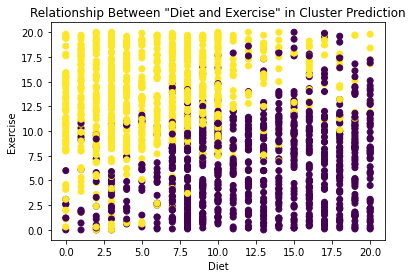

In [213]:
import matplotlib.pyplot as plt

predictions = predictions.toPandas()
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(predictions["Diet"], predictions["Exercise"], c=predictions["prediction"])
ax.set_title('Relationship Between "Diet and Exercise" in Cluster Prediction')
ax.set_xlabel('Diet')
ax.set_ylabel('Exercise')
plt.show()

In [214]:
c = 0
for index, row in predictions.iterrows():
    if row["Healthy"] == row["prediction"]:
        c = c + 1

print("Accuracy: {}%".format(c / len(predictions) * 100))

Accuracy: 81.26373626373626%
